# Analyzing Hotels based on user Reviews

What data I am using? 
The data has been taken from Kaggle - "https://www.kaggle.com/datafiniti/hotel-reviews".

About the data:
- A list of 1,000 hotels and their reviews.
- Dataset includes hotel location, name, rating, review data, title, username, and more.

In [1]:
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.dummy import *
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.naive_bayes import *
from sklearn.decomposition import *
from sklearn.preprocessing import *
from sklearn.neighbors import *
from sklearn.feature_selection import *
from sklearn.ensemble import *
from sklearn.cluster import *
from sklearn import naive_bayes as nb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as cv
from cytoolz import *

from sklearn.metrics.pairwise import *
from scipy.cluster.hierarchy import *
from scipy.spatial.distance import *
from collections import defaultdict

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.graph_objs as go
%matplotlib inline
pd.set_option('display.max_colwidth', 200)


## Step 1: Data Ingesstion

In [41]:
#This code is not working

# since I am working in python 2.7, I need to make sure to clean the data to make it unicode consistent
#def clean(text):
#    return unicode(''.join([i if ord(i) < 128 else ' ' for i in text]))

#data = nlp(clean(data))

In [2]:
# Reading dataset.
data = pd.read_csv("./data.csv")

In [3]:
data.head(1).T

,0
address,Riviera San Nicol 11/a
categories,Hotels
city,Mableton
country,US
latitude,45.4216
longitude,12.3762
name,Hotel Russo Palace
postalCode,30126
province,GA
reviews.date,2013-09-22T00:00:00Z


In [64]:
# shape of data
data.shape

(35912, 19)

In [65]:
# Features of Data
data.columns

Index(['address', 'categories', 'city', 'country', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateAdded',
       'reviews.doRecommend', 'reviews.id', 'reviews.rating', 'reviews.text',
       'reviews.title', 'reviews.userCity', 'reviews.username',
       'reviews.userProvince'],
      dtype='object')

In [66]:
# describing data
data.describe()

,latitude,longitude,reviews.doRecommend,reviews.id,reviews.rating
count,35826.000000,35826.000000,0.0,0.0,35050.000000
mean,37.285008,-85.725758,NaN,NaN,3.776431
std,6.996544,33.062263,NaN,NaN,1.416195
min,-25.436750,-166.559040,NaN,NaN,0.000000
25%,33.827340,-104.868200,NaN,NaN,3.000000
50%,37.936026,-86.822972,NaN,NaN,4.000000
75%,41.672491,-77.044550,NaN,NaN,5.000000
max,63.877674,115.164407,NaN,NaN,10.000000


## Step 2: Data Exploration

I explored the data for finding any interesting patterns or correlations.
- Check if the reviews were by same users
- Finding hotels with highest number of reviews
- Checking countries of hotel reviews
- Checking average User ratings.
- Checking the months where people travel most

In [67]:
# Check if the reviews were by same users
len(data['reviews.username'].unique())

15493

In [68]:
# Finding hotels with highest number of reviews - Showing top 10 Hotels of all 1000 Hotels
data['name'].value_counts().reset_index().head(10)

,index,name
0,"The Alexandrian, Autograph Collection",1185
1,Howard Johnson Inn - Newburgh,714
2,Americas Best Value Inn,567
3,Fiesta Inn and Suites,546
4,Ip Casino Resort Spa,392
5,Best Western Plus Waterville Grand Hotel,335
6,Hampton Inn Virginia Beach Oceanfront North,334
7,Comfort Suites,326
8,New York Marriott Marquis,320
9,Best Western of Long Beach,317


In [69]:
# Checking countries of hotel reviews
data['country'].unique()

array(['US'], dtype=object)

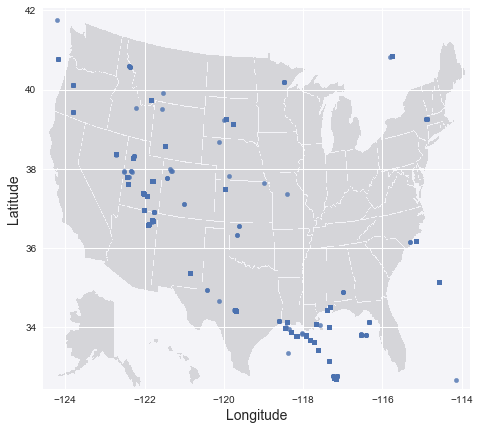

In [17]:
# Plotting co-ordinate for hotels

import matplotlib.image as mpimg
us_img=mpimg.imread('USimage.png')
# c is the attribute we'll map onto colors, s is the attribute we'll represent with circle size.
ax = data.plot(kind="scatter", x="longitude", y="latitude", figsize=(15,7),colorbar=False, alpha=0.8)

plt.imshow(us_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

                       
plt.legend(fontsize=16)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123565ba8>]], dtype=object)

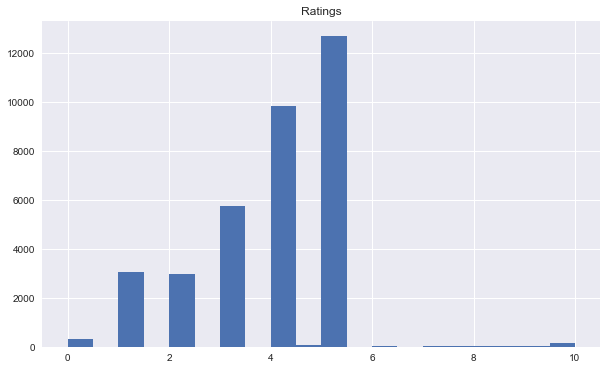

In [72]:
# Plotting User ratings.
plt.rcParams['figure.figsize'] = (10, 6)
scores = pd.DataFrame({"Ratings":data["reviews.rating"]})
scores.hist(bins=20)

**Note:** We see that most of the reviews have been 5, very few reviews are above 5. This is why in later section we will be converting this to a binary class as :

>>
- **0** - Negative i.e reviews rating < 5
- **1** - Positive i.e reviews rating >= 5

In [18]:
# Adding additional columns for Date / Time
data['reviews.dateAdded'] = pd.to_datetime(data['reviews.dateAdded'], errors='coerce')
data['reviews.day'] = pd.DatetimeIndex(data['reviews.dateAdded']).day 
data['reviews.month'] = pd.DatetimeIndex(data['reviews.dateAdded']).month
data['reviews.year'] = pd.DatetimeIndex(data['reviews.dateAdded']).year 

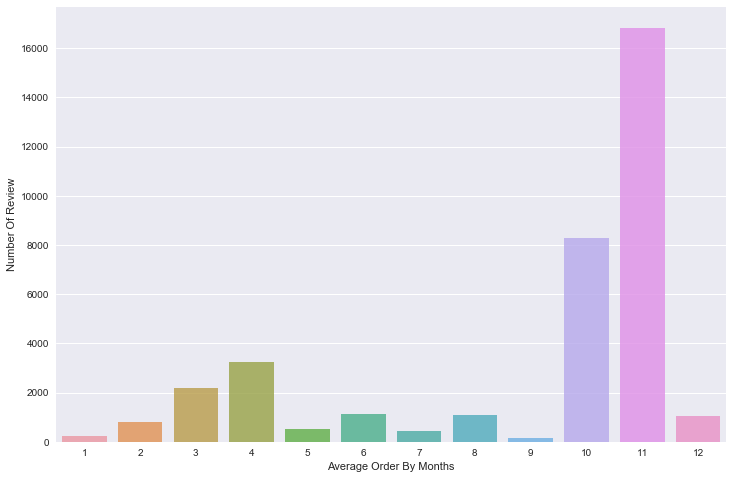

In [74]:
# Checking the months when people travel most
plt.figure(figsize=(12,8))
Reviews_Count_Month = data['reviews.month'].value_counts()
sb.barplot(Reviews_Count_Month.index, Reviews_Count_Month.values, alpha=0.8)
plt.ylabel("Number Of Review")
plt.xlabel("Average Order By Months")
plt.show()

**Note:** We see that most travels took place around the months of November and October

## Step 3: Data Cleaning

In the data cleaning step we perform following tasks -
- Drop Columns from main dataset that are mostly null
- Create a subset dataframe with only reviews data as it is most important part of the project
- Remove all null values
- Set classes of reviews as binary - 0 & 1
- Merge review.text and review.title into single reviews
- Drop non-english reviews
- Tokenize the sentences

In [3]:
# Check for Null
data.isnull().sum()

address                     0
categories                  0
city                        0
country                     0
latitude                   86
longitude                  86
name                        0
postalCode                 55
province                    0
reviews.date              259
reviews.dateAdded           0
reviews.doRecommend     35912
reviews.id              35912
reviews.rating            862
reviews.text               22
reviews.title            1621
reviews.userCity        19649
reviews.username           43
reviews.userProvince    18394
dtype: int64

**Note:** From above we see that following columns have large number of missing values - [reviews.doRecommend, reviews.id, reviews.userCity, reviews.userProvince] hence we will drop these columns from dataset itself as these values can't be imputed.

In [19]:
#Drop Columns with lot of missing values 
data = data.drop(['reviews.doRecommend','reviews.id','reviews.userCity','reviews.userProvince'],axis=1)

In [20]:
# Getting subset of data where we need relevant features
data_reviews= data[['reviews.title','reviews.text','reviews.rating']]

In [21]:
# Getting rid of NULL rows in reviews dataframe
data_reviews=data_reviews.dropna(axis=0,how='any')

In [7]:
data_reviews.head(5)

,reviews.title,reviews.text,reviews.rating
0,Good location away from the crouds,Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!,4.0
1,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top floor and were surprised by a Jacuzzi bath we didn't know we were getting! Staff were friendly and helpful and the included breakfast was great! Great l...,5.0
2,Lugnt l��ge,Ett mycket bra hotell. Det som drog ner betyget var att vi fick ett rum under taksarna dr det endast var full sthjd i 80 av rummets yta.,5.0
3,Good location on the Lido.,"We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comfortable- good shower, light...",5.0
4,������ ���������������,"We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comfortable- good shower, light...",5.0


### 1. Setting Binary Class for Reviews

In [159]:
# Checking Review Classes
data_reviews['reviews.rating'].value_counts()

5.0     12319
4.0      9699
3.0      5627
1.0      2985
2.0      2968
10.0      101
0.0        84
9.6        53
9.2        49
4.3        26
8.3        25
8.8        24
7.9        24
7.5        24
4.2        22
4.1        14
6.3        14
7.1        13
6.7        12
5.4         9
4.6         7
3.1         7
5.8         6
3.3         6
4.5         6
4.7         4
4.8         4
4.4         4
3.8         3
2.5         3
3.7         2
4.9         2
3.2         2
6.0         1
2.9         1
7.0         1
2.8         1
3.9         1
3.4         1
1.5         1
9.5         1
Name: reviews.rating, dtype: int64

**Note:** We can see here that the class is imbalance, reviews rating range from 0 to 10. There are more reviews with ratings less than and equal to 6 and less reviews for higher rating. We will make the classification as binary.

**`Ratings < 5: 0`**

**`Ratings >= 5: 1`**

In [22]:
data_reviews['review_label']=data_reviews['reviews.rating'].apply(lambda x: 0 if x<5 else 1)

In [23]:
data_reviews.head(5)

,reviews.title,reviews.text,reviews.rating,review_label
0,Good location away from the crouds,Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!,4.0,0
1,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top floor and were surprised by a Jacuzzi bath we didn't know we were getting! Staff were friendly and helpful and the included breakfast was great! Great l...,5.0,1
2,Lugnt l��ge,Ett mycket bra hotell. Det som drog ner betyget var att vi fick ett rum under taksarna dr det endast var full sthjd i 80 av rummets yta.,5.0,1
3,Good location on the Lido.,"We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comfortable- good shower, light...",5.0,1
4,������ ���������������,"We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comfortable- good shower, light...",5.0,1


In [24]:
# Checking Count of +ve and -ve Reviews
len(data_reviews[data_reviews['review_label']==0]),len(data_reviews[data_reviews['review_label']==1])

(21480, 12676)

### 2. Combining Review Title and Review Text

In [25]:
# Creating an empty series to ensure merge has space between two joining words 
temp = pd.Series([' ']*data_reviews.shape[0])

# merging all reviews
data_reviews['reviews.all']=data_reviews['reviews.title']+temp+data_reviews['reviews.text']

In [21]:
data_reviews.head(5)

,reviews.title,reviews.text,reviews.rating,review_label,reviews.all
0,Good location away from the crouds,Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!,4.0,0,Good location away from the crouds Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work v...
1,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top floor and were surprised by a Jacuzzi bath we didn't know we were getting! Staff were friendly and helpful and the included breakfast was great! Great l...,5.0,1,Great hotel with Jacuzzi bath! Really lovely hotel. Stayed on the very top floor and were surprised by a Jacuzzi bath we didn't know we were getting! Staff were friendly and helpful and the includ...
2,Lugnt l��ge,Ett mycket bra hotell. Det som drog ner betyget var att vi fick ett rum under taksarna dr det endast var full sthjd i 80 av rummets yta.,5.0,1,Lugnt l��ge Ett mycket bra hotell. Det som drog ner betyget var att vi fick ett rum under taksarna dr det endast var full sthjd i 80 av rummets yta.
3,Good location on the Lido.,"We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comfortable- good shower, light...",5.0,1,"Good location on the Lido. We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comf..."
4,������ ���������������,"We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comfortable- good shower, light...",5.0,1,"������ ��������������� We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comforta..."


### 3. Dropping Non-english reviews:
This step is being taken to reduce complexity due to different languages used in reviews. 

**Note:** I merged the *reviews.title and reviews.text* columns before detecting english user might give review in title itself, or skip the title and give comment in body.

In [26]:
from langdetect import detect
from langdetect import detect_langs
from langdetect import DetectorFactory 
DetectorFactory.seed = 0

***NOTE:*** Language detection algorithm is non-deterministic, which means that if you try to run it on a text which is either too short or too ambiguous, you might get different results everytime you run it. To enforce consistent results, call following code before the first language detection:
`python from langdetect import DetectorFactory DetectorFactory.seed = 0 `

https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes
https://pypi.org/project/langdetect/

In [27]:
# Non-English Review
print(data['reviews.text'][2])
detect(data['reviews.text'][2])

Ett mycket bra hotell. Det som drog ner betyget var att vi fick ett rum under taksarna dr det endast var full sthjd i 80 av rummets yta.


u'sv'

In [89]:
# English Review
print(data['reviews.text'][3])
detect(data['reviews.text'][3])

We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comfortable- good shower, light and airy rooms with windows you could open wide. Beds were comfortable. Plenty of choice for breakfast.Spa at hotel nearby which we used while we were there.


'en'

In [28]:
# Getting rid of Non-English reviews
def remove_foreign_lang(x):
    try:
        if detect(x)!='en':
            x=np.nan        
    except: 
        x=np.nan
    return x

In [29]:
# Detecting Non-English Reviews in 'reviews.all' and setting it to NaN
data_reviews['reviews.all']=data_reviews['reviews.all'].apply(remove_foreign_lang)
data_reviews.head(5)

,reviews.title,reviews.text,reviews.rating,review_label,reviews.all
0,Good location away from the crouds,Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!,4.0,0,Good location away from the crouds Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work v...
1,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top floor and were surprised by a Jacuzzi bath we didn't know we were getting! Staff were friendly and helpful and the included breakfast was great! Great l...,5.0,1,Great hotel with Jacuzzi bath! Really lovely hotel. Stayed on the very top floor and were surprised by a Jacuzzi bath we didn't know we were getting! Staff were friendly and helpful and the includ...
2,Lugnt l��ge,Ett mycket bra hotell. Det som drog ner betyget var att vi fick ett rum under taksarna dr det endast var full sthjd i 80 av rummets yta.,5.0,1,NaN
3,Good location on the Lido.,"We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comfortable- good shower, light...",5.0,1,"Good location on the Lido. We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comf..."
4,������ ���������������,"We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comfortable- good shower, light...",5.0,1,NaN


In [30]:
# Creating dataframe of only English reviews - 
data_reviews_english=data_reviews

In [26]:
# Checking new data shape
data_reviews_english.isnull().sum()

reviews.title        0
reviews.text         0
reviews.rating       0
review_label         0
reviews.all       3270
dtype: int64

In [31]:
# Dropping Non-English Reviews from dataframe
data_reviews_english=data_reviews_english.dropna(axis=0, how='any')
data_reviews_english.isnull().sum()

reviews.title     0
reviews.text      0
reviews.rating    0
review_label      0
reviews.all       0
dtype: int64

### 4. Text Normalization & Tokenization

In [44]:
import spacy
# Load Spacy
nlp = spacy.load('en')
nlp = spacy.load('en', dhttp://localhost:8888/notebooks/Documents/chotu%20doggy/Spring_2018/LING583_Text%20Analysis/LING583_Project_Final.ipynb#4.-Text-Normalization-&-Tokenizationisable=['tagger', 'ner', 'parser'])

import string
import re
from re import sub

import nltk
from nltk import sent_tokenize
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

In [33]:
# Cleaning The reviews -
# 1. Converting to Lower case
# 2. Removing special characters, digits
data_reviews_english['reviews.all']=data_reviews_english['reviews.all'].str.lower().str.replace(r'(\W|\d)+', ' ')

/Users/Smiley/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [86]:
#Remove stop words (this step is optional, if you are not satisfied with spacy's action):
def remove_stopwords(token):
    return [w for w in token if not w in stopwords.words('english')]


my_stop_words = [u'say', u'\'s', u'Mr', u'be', u'said', u'says', u'saying',u'hotel',u'the',u'and',u'to',u'it',u'for',u'a']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True



data_reviews_english['tokens']=data_reviews_english['reviews.all'].apply(remove_stopwords)

In [87]:
# Tokenizer Function
def tokenize(text):
    x = nlp(unicode(text))
    return x.text.split()
    #return [tok.lemma_ for tok in nlp.tokenizer(text)]

In [88]:
data_reviews_english['tokens'] = data_reviews_english['reviews.all'].apply(tokenize)

In [89]:
# Data Structure
data_reviews_english.head(3)

,reviews.title,reviews.text,reviews.rating,review_label,reviews.all,tokens
0,Good location away from the crouds,Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!,4.0,0,good location away from the crouds pleasant min walk along the sea front to the water bus restaurants etc hotel was comfortable breakfast was good quite a variety room aircon didn t work very well...,"[good, location, away, from, the, crouds, pleasant, min, walk, along, the, sea, front, to, the, water, bus, restaurants, etc, hotel, was, comfortable, breakfast, was, good, quite, a, variety, room..."
1,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top floor and were surprised by a Jacuzzi bath we didn't know we were getting! Staff were friendly and helpful and the included breakfast was great! Great l...,5.0,1,great hotel with jacuzzi bath really lovely hotel stayed on the very top floor and were surprised by a jacuzzi bath we didn t know we were getting staff were friendly and helpful and the included ...,"[great, hotel, with, jacuzzi, bath, really, lovely, hotel, stayed, on, the, very, top, floor, and, were, surprised, by, a, jacuzzi, bath, we, didn, t, know, we, were, getting, staff, were, friendl..."
3,Good location on the Lido.,"We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comfortable- good shower, light...",5.0,1,good location on the lido we stayed here for four nights in october the hotel staff were welcoming friendly and helpful assisted in booking tickets for the opera the rooms were clean and comfortab...,"[good, location, on, the, lido, we, stayed, here, for, four, nights, in, october, the, hotel, staff, were, welcoming, friendly, and, helpful, assisted, in, booking, tickets, for, the, opera, the, ..."


**NOTE:** I propose to build additional column which contain just adjectives. But at the same time skeptical if that would be helpful since people use different figure of speech while giving their reviews.

`It was interesting - referring to a bad or difficult experience` 

Professor can you share your thoughts if this column can bring values?

### 5. Splitting Data: Train & Test

In [49]:
X_train, X_test,Y_train, Y_test = train_test_split(data_reviews_english['tokens'], data_reviews_english['review_label'], test_size=.2)

In [50]:
# Checking shape of test and train
print(X_train.shape,X_test.shape)

((24596,), (6149,))


In [51]:
# Checking distribution of Classes after removal of non-english text
len(data_reviews_english[data_reviews_english['review_label']==0]),len(data_reviews_english[data_reviews_english['review_label']==1])

(19287, 11458)

## Step 4: Buidling Sentiment Classifier Model

### Preprocessing Baseline

In [52]:
folds = StratifiedKFold(shuffle=True, n_splits=10, random_state=10)

In [50]:
baseline = make_pipeline(CountVectorizer(analyzer=identity), DummyClassifier())

In [51]:
base_score = cross_val_score(baseline, X_train, Y_train, cv=folds)
base_score.mean(), base_score.std()

(0.53083983196574802, 0.0093245676290109377)

### 1. Simple Logistic Regression

In [52]:
lr = make_pipeline(CountVectorizer(analyzer=identity), LogisticRegression() )

In [53]:
lr_score = cross_val_score(lr, X_train, Y_train, cv=folds)
lr_score.mean(), lr_score.std()

(0.77816887314476113, 0.0080376105660789413)

**Note:** Since this is a simple logistic regression, I will try to improve the accuracy in later two classifiers.

### 2.  Hypertuning Logistic Regression

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

In [54]:
lr2 = make_pipeline(CountVectorizer(analyzer=identity),LogisticRegression())

In [55]:
params = {'logisticregression__penalty': ['l2'],
          'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10.0],
          'countvectorizer__min_df': [1, 2, 5],
          'countvectorizer__max_df': [0.1, 0.25, 0.5]}
grid_search = GridSearchCV(lr2, params, n_jobs=-1, verbose=1, return_train_score=True)
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  5.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x110c797d0>, binary=False,
        decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), prepro...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'countvectorizer__min_df': [1, 2, 5], 'logisticregression__penalty': ['l2'], 'countvectorizer__max_df': [0.1, 0.25, 0.5], 'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [56]:
grid_search.best_score_, grid_search.best_params_

(0.78431452268661572,
 {'countvectorizer__max_df': 0.5,
  'countvectorizer__min_df': 1,
  'logisticregression__C': 0.1,
  'logisticregression__penalty': 'l2'})

In [57]:
lr2.set_params(**grid_search.best_params_).fit(X_train, Y_train)
score=cross_val_score(lr2,X_train, Y_train, cv=folds, n_jobs=-1)
score.mean(), score.std()

(0.78581887888914426, 0.0044633992975753236)

### Evaluating Accuracy
**NOTE:** This functions will be reused by classifiers in later section

In [63]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score as auc_score

In [64]:
def model_evaluation(model,label_test):
    # confusion matrix:
    cm = confusion_matrix(label_test, model, labels=None, sample_weight=None)    
    # true positive(tp) / false negative(fn) / false positive(fp) / true negaive(tn)
    tp, fn, fp, tn = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    # precision
    precision= float(tp)/(tp+fp)
    # recall
    recall =  float(tp)/(tp+tn)
    # accuracy
    accuracy = np.mean(model == label_test)
    
    # print results
    print_results (precision, recall, accuracy)    
    # plot the curve
    plot_roc_graph(model,label_test)
    # return accuracy, precision, recall values
    #return accuracy,precision,recall

In [65]:
def print_results (precision, recall, accuracy):
    banner = "Here is the classification report"
    print ('\n',banner)
    print ('=' * len(banner))
    print ('{0:10s} {1:.1f}'.format('Precision',precision*100))
    print ('{0:10s} {1:.1f}'.format('Recall',recall*100))
    print ('{0:10s} {1:.1f}'.format('Accuracy',accuracy*100))

In [66]:
def plot_roc_graph(label_predicted,label_test):
    plt.rcParams['figure.figsize'] = (10, 6)    
    # Plot ROC Curve
    fpr, tpr, _ = metrics.roc_curve(label_test,label_predicted)
    # calculate AUC score
    auc = auc_score(label_test, label_predicted)
    plt.plot(fpr,tpr,label="data, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

In [67]:
#predicting test set
predicted=lr2.predict(X_test)
# Creating a pd series for result
predicted1=pd.Series(data=predicted, index=range(0,X_test.shape[0]))

('\n', 'Here is the classification report')
Precision  82.5
Recall     68.1
Accuracy   79.5


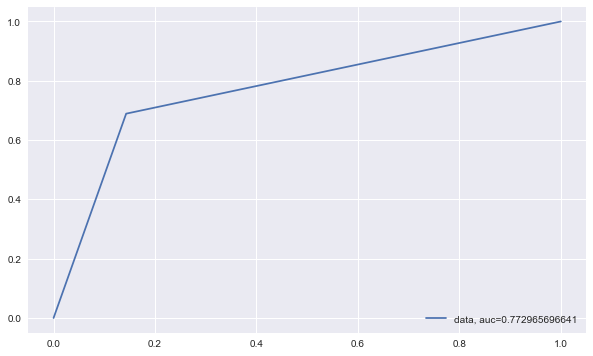

In [68]:
# Evaluating the Model
model_evaluation(predicted,Y_test)

In [133]:
# Generating result frame
temp={'Review': list(X_test), 'TrueClass': list(Y_test), 'PredictedClass': list(predicted1)}
l2_2_result = pd.DataFrame(temp, columns = ['Review', 'TrueClass', 'PredictedClass'])

In [134]:
l2_2_result.head(10)

,Review,TrueClass,PredictedClass
0,"[weekend, visit, we, stayed, here, for, parents, weekend, at, tjc, all, of, the, staff, were, very, friendly, and, helpful, the, room, was, super, clean, the, breakfast, was, wonderful, many, opti...",1,1
1,"[very, dirty, carpet, i, ve, never, seen, more, dirty, carpet, in, a, room, absolutely, disgusting]",0,0
2,"[business, trip, the, staff, where, friendly, and, professional, the, cleaning, staff, accidentally, left, used, towels, in, the, bathroom, i, truly, believe, ti, was, not, done, on, purpose, the,...",0,0
3,"[overall, a, good, stay, the, staff, were, kind, and, attentive, our, room, was, spotless, and, well, maintained, the, housekeeping, staff, were, kind, as, well, the, free, breakfast, was, good, t...",0,0
4,"[great, property, great, staff, grace, was, so, helpful, and, has, a, contagious, personality, which, made, our, stay, a, pleasure, the, property, was, clean, even, though, it, could, use, some, c...",0,1
5,"[priced, well, under, comfy, accommodations, would, stay, here, again, the, lobby, furniture, is, a, bit, out, of, place, however, the, rooms, are, a, good, size, and, the, beds, comfortable, brea...",0,0
6,"[wonderful, stay, ip, is, a, beautiful, romantic, type, hotel, we, stayed, here, on, our, wedding, night, and, decided, to, come, back, for, our, one, year, anniversary, and, it, was, awesome, fro...",1,1
7,"[great, stay, very, comfortable, and, clean, restaurant, staff, was, very, hospitable, and, the, food, was, great]",1,1
8,"[weekend, stay, for, barksdale, air, show, to, share, your, opinion, of, this, businesswith, yp, visitors, across, the, united, statesand, in, your, neighborhood]",0,0
9,"[top, class, in, every, respect, i, don, t, even, know, where, to, start, to, describe, what, an, amazing, time, we, had, staying, at, villa, carlotta, from, the, moment, we, go, their, we, were, ...",1,1


## 3. Hypertuning Logistic Regression using Tfidf

In [141]:
lr3 = make_pipeline(CountVectorizer(analyzer=identity),
                    TfidfTransformer(),
                    LogisticRegression())

In [136]:
### takes lot of time to run
params2 = {'tfidftransformer__norm': ['l3', None],
           'tfidftransformer__use_idf': [True, False],
           'tfidftransformer__sublinear_tf': [True, False],
           'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10.0],
           'countvectorizer__min_df': [1, 2, 5],
           'countvectorizer__max_df': [0.1, 0.25, 0.5, 0.75, 1.0]}

grid_search2 = GridSearchCV(lr3, params2, n_jobs=-1, verbose=1, return_train_score=True)
grid_search2.fit(X_train, Y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 25.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x10f836270>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproce...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'tfidftransformer__norm': ['l2', None], 'tfidftransformer__use_idf': [True, False], 'tfidftransformer__sublinear_tf': [True, False], 'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10.0], 'countvectorizer__min_df': [1, 2, 5], 'countvectorizer__max_df': [0.1, 0.25, 0.5, 0.75, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [137]:
best_score = cross_val_score(lr3, X_train, Y_train, cv=folds)
best_score.mean(), best_score.std()

(0.78865065623935093, 0.0073570166196195346)

In [143]:
grid_search2.best_score_, grid_search2.best_params_

(0.78942043062975553,
 {'countvectorizer__max_df': 1.0,
  'countvectorizer__min_df': 2,
  'logisticregression__C': 0.001,
  'tfidftransformer__norm': None,
  'tfidftransformer__sublinear_tf': False,
  'tfidftransformer__use_idf': True})

In [145]:
lr3.set_params(**grid_search2.best_params_).fit(X_train, Y_train)
score2=cross_val_score(lr3,X_train, Y_train, cv=folds, n_jobs=-1)
score2.mean(), score2.std()

(0.79229349641749514, 0.0073854516873124608)

In [155]:
#predicting test set
predicted2=lr3.predict(X_test)
# Creating a pd series for result
predicted3=pd.Series(data=predicted2, index=range(0,X_test.shape[0]))


 Here is the classification report
Precision  81.5
Recall     67.5
Accuracy   78.9


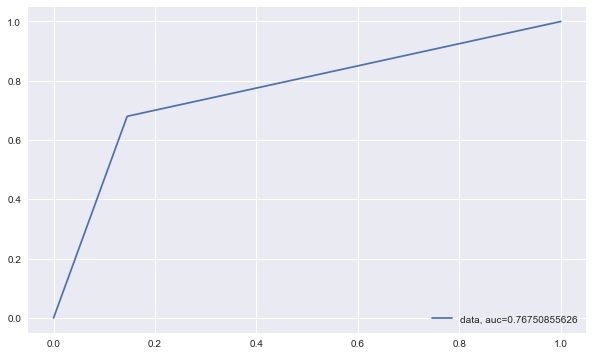

In [156]:
# Evaluating the Model
model_evaluation(predicted2,Y_test)

**Note:** We see a minute improvement of performance over lr2(Hypertuned Logistic Regression with Countvectorizer) and lr(Simple Logistic Regression)

In [157]:
# Generating result frame
temp2={'Review': list(X_test), 'TrueClass': list(Y_test), 'PredictedClass': list(predicted3)}
lr_3_result = pd.DataFrame(temp, columns = ['Review', 'TrueClass', 'PredictedClass'])

In [158]:
lr_3_result.head(10)

,Review,TrueClass,PredictedClass
0,"[weekend, visit, we, stayed, here, for, parents, weekend, at, tjc, all, of, the, staff, were, very, friendly, and, helpful, the, room, was, super, clean, the, breakfast, was, wonderful, many, opti...",1,1
1,"[very, dirty, carpet, i, ve, never, seen, more, dirty, carpet, in, a, room, absolutely, disgusting]",0,0
2,"[business, trip, the, staff, where, friendly, and, professional, the, cleaning, staff, accidentally, left, used, towels, in, the, bathroom, i, truly, believe, ti, was, not, done, on, purpose, the,...",0,0
3,"[overall, a, good, stay, the, staff, were, kind, and, attentive, our, room, was, spotless, and, well, maintained, the, housekeeping, staff, were, kind, as, well, the, free, breakfast, was, good, t...",0,0
4,"[great, property, great, staff, grace, was, so, helpful, and, has, a, contagious, personality, which, made, our, stay, a, pleasure, the, property, was, clean, even, though, it, could, use, some, c...",0,1
5,"[priced, well, under, comfy, accommodations, would, stay, here, again, the, lobby, furniture, is, a, bit, out, of, place, however, the, rooms, are, a, good, size, and, the, beds, comfortable, brea...",0,0
6,"[wonderful, stay, ip, is, a, beautiful, romantic, type, hotel, we, stayed, here, on, our, wedding, night, and, decided, to, come, back, for, our, one, year, anniversary, and, it, was, awesome, fro...",1,1
7,"[great, stay, very, comfortable, and, clean, restaurant, staff, was, very, hospitable, and, the, food, was, great]",1,1
8,"[weekend, stay, for, barksdale, air, show, to, share, your, opinion, of, this, businesswith, yp, visitors, across, the, united, statesand, in, your, neighborhood]",0,0
9,"[top, class, in, every, respect, i, don, t, even, know, where, to, start, to, describe, what, an, amazing, time, we, had, staying, at, villa, carlotta, from, the, moment, we, go, their, we, were, ...",1,1


## 4. Bernoulli NB

In [159]:
nb = make_pipeline(CountVectorizer(min_df=2, max_df=0.5, analyzer=identity), BernoulliNB())     
score = cross_val_score(nb, X_train, Y_train, cv=5, n_jobs=-1)
score.mean(), score.std()

(0.72587716294440607, 0.0082223043998568297)

**Note**: Performance of Bernoulli NB is worse than Logistic Regression,hence I will not use this classifier.

## 5. Multinomial NB

In [165]:
mnb = make_pipeline(CountVectorizer(min_df=2, max_df=0.5, analyzer=identity), MultinomialNB())     
score = cross_val_score(mnb, X_train, Y_train, cv=folds, n_jobs=-1)
score.mean(), score.std()

(0.75857939952784004, 0.0076006926036304885)

**Note**: Performance of Multinomial NB is worse than Logistic Regression,hence I will not use this classifier.

## 6. K Nearest Neighbors

In [58]:
knn = make_pipeline(CountVectorizer(analyzer=identity), 
                    SelectKBest(mutual_info_classif),
                    KNeighborsClassifier(metric='cosine',algorithm='brute'))

In [59]:
params = {'kneighborsclassifier__n_neighbors': [2, 5, 10, 25, 50],
          'countvectorizer__min_df': [1, 2],
          'countvectorizer__max_df': [0.25, 0.5]}
grid_search = GridSearchCV(knn, params, n_jobs=3, return_train_score=True)
grid_search.fit(X_train,Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x110c797d0>, binary=False,
        decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), prepro...osine',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'countvectorizer__min_df': [1, 2], 'kneighborsclassifier__n_neighbors': [2, 5, 10, 25, 50], 'countvectorizer__max_df': [0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [60]:
grid_search.best_params_

{'countvectorizer__max_df': 0.5,
 'countvectorizer__min_df': 1,
 'kneighborsclassifier__n_neighbors': 50}

In [61]:
knn.set_params(**grid_search.best_params_)
knn_score = cross_val_score(knn, X_train, Y_train, cv=folds, n_jobs=-1)
knn_score.mean(), knn_score.std()

(0.70885525546586137, 0.012035984580189767)

### Model Evaluation

In [69]:
print(classification_report(Y_test, predicted))

             precision    recall  f1-score   support

          0       0.83      0.86      0.84      3885
          1       0.74      0.69      0.71      2264

avg / total       0.79      0.80      0.79      6149



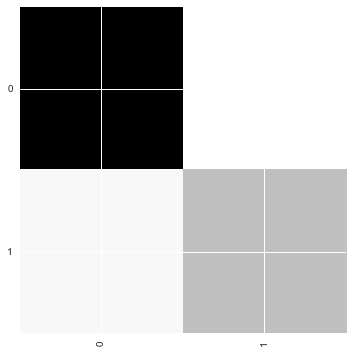

In [80]:
review = pd.unique(data_reviews_english['review_label'])
cm = confusion_matrix(Y_test, predicted, labels=review)
plt.imshow(cm)

plt.xticks(range(len(review)), review, rotation=90)
plt.yticks(range(len(review)), review, rotation=0)
plt.show()

## Step 5: Indentifying Positive and Negative Words

In this step we will identify positive and negative words used in reviews. We will be using the **PMI** technique. 

### PMI - 
To find evaluative language, we'll want to use pointwise mutual information to find words that occur in a subset of review texts with greater than chance frequency:

$$PMI(w, subset)=\log_2\frac{f(w, subset)\times N}{f(w)\times N(subset)}$$
To calculate this, we need the frequency of a word in a subset $f(w, subset)$, the overall frequency of a word $f(w)$, the number of words in a subset $N(subset)$, and the total number of words $N$.

In [174]:
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk import pos_tag
from nltk.corpus import stopwords

In [179]:
# 2. Now, count overall frequencies:
words = pd.DataFrame({'all': pd.value_counts(list(concat(data_reviews_english['tokens'])))})
words[:10]

,all
hotel,20915
room,20156
stay,14704
great,13608
clean,10474
staff,10444
nice,10403
good,9158
breakfast,8181
place,6014


In [180]:
# 3. Filter words for Negative Reviews
words['bad'] = pd.value_counts(list(concat(data_reviews_english[data_reviews_english['review_label']==0]['tokens'])))
words[:5]

,all,bad
hotel,20915,13182.0
room,20156,14908.0
stay,14704,8367.0
great,13608,5887.0
clean,10474,6225.0


In [182]:
# 4. Dropping null values
print("before".words.isnull().sum())
words.dropna()
print("after",words.isnull().sum())

all       0
bad    3926
dtype: int64
all       0
bad    3926
dtype: int64


In [183]:
# 5. Calculating PMI of Bad Words
words['bad_pmi'] = np.log2((words['bad'] * np.sum(words['all'])) / 
                        (words['all'] * np.sum(words['bad'])) )

In [184]:
# 6. Listing the words - Bad
words['bad_pmi'].sort_values(ascending=False)[:10]

roro              0.608196
metered           0.608196
melon             0.608196
excruciatingly    0.608196
bagged            0.608196
midvale           0.608196
flys              0.608196
plugging          0.608196
animas            0.608196
ramps             0.608196
Name: bad_pmi, dtype: float64

In [185]:
# 7. Avoiding rare used words  
words['bad_pmi'][words['all']>25].sort_values(ascending=False)[:10]

rug             0.608196
yelling         0.608196
supposedly      0.608196
marijuana       0.608196
refused         0.608196
tiles           0.608196
roach           0.608196
businesswith    0.608196
prepaid         0.608196
yp              0.608196
Name: bad_pmi, dtype: float64

In [187]:
#!pip install wordcloud

In [188]:
from wordcloud import WordCloud
pd.set_option('precision', 2)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 250)

%matplotlib inline

### Word Cloud : Negative Words in Reviews

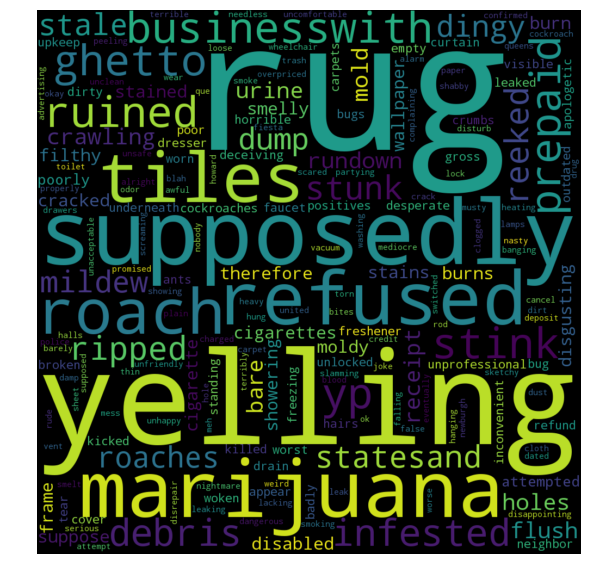

In [197]:
#constructing a dictionary for bad words 
vn = dict(words['bad_pmi'][words['all']>25].sort_values(ascending=False)[:200])
i = WordCloud(width=1000,height=1000).generate_from_frequencies(vn).to_image()
plt.figure(figsize=(20,10))
plt.imshow(i,interpolation='bilinear')
plt.axis('off')
plt.show()

### Word Cloud : Positive Words in Reviews

In [191]:
words['good'] = pd.value_counts(list(concat(data_reviews_english[data_reviews_english['review_label']==1]['tokens'])))
words['good_pmi'] = np.log2((words['good'] * np.sum(words['all'])) / 
                         (words['all'] * np.sum(words['good'])))

#constructing a dictionary for good words 
vp = dict(words['good_pmi'][words['all']>25].sort_values(ascending=False)[:200])
i = WordCloud(width=1000,height=1000).generate_from_frequencies(vp).to_image()

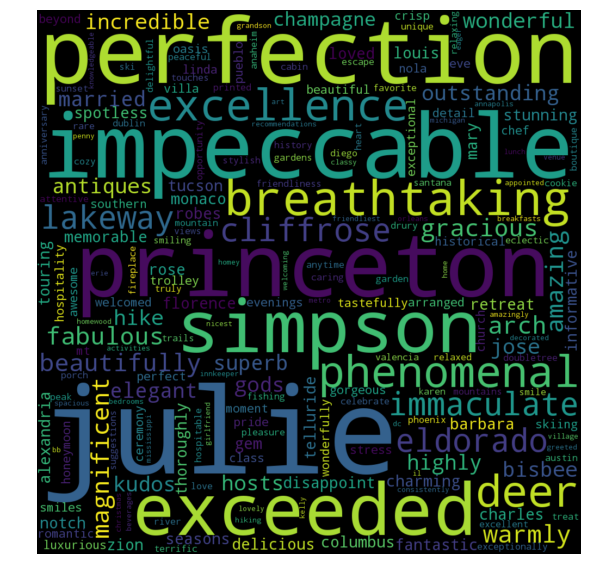

In [196]:
plt.figure(figsize=(20,10))
plt.imshow(i,interpolation='bilinear')
plt.axis('off')
plt.show()

In [212]:
#  Listing the words- Bad
words['good_pmi'].sort_values(ascending=False)[10:20]

kaylin         1.54
friendship     1.54
basins         1.54
containing     1.54
artery         1.54
candle         1.54
seattlecity    1.54
recepcin       1.54
statio         1.54
ethics         1.54
Name: good_pmi, dtype: float64

##  Step 6: Topic Modelling

In [219]:
#!pip install gensim
#!pip install pyLDAvis

In [82]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

In [83]:
#bigram
bigram = gensim.models.Phrases(data_reviews_english['tokens'])
#texts
texts = [bigram[line] for line in data_reviews_english['tokens']]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

### LSI
LSI stands for Latent Semantic Indeixing - it is a popular information retreival method which works by decomposing the original matrix of words to maintain key topics. Gensim's implementation uses an SVD.

In [84]:
lsimodel = LsiModel(corpus=corpus, num_topics=2, id2word=dictionary)

In [85]:
lsimodel.show_topics(num_topics=2)  # Showing only the top 2 topics

[(0,
  u'0.643*"the" + 0.351*"and" + 0.284*"was" + 0.251*"to" + 0.250*"a" + 0.176*"i" + 0.160*"in" + 0.139*"we" + 0.121*"room" + 0.117*"it"'),
 (1,
  u'-0.719*"the" + 0.341*"a" + 0.322*"and" + 0.272*"i" + 0.223*"to" + 0.189*"was" + 0.114*"for" + 0.097*"it" + 0.097*"stay" + 0.087*"very"')]

### HDP
HDP, the Hierarchical Dirichlet Process is an unsupervised topic model which figures out the number of topics on it's own.

In [226]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [227]:
hdpmodel.show_topics()

[(0,
  '0.027*room + 0.025*hotel + 0.016*stay + 0.015*great + 0.012*clean + 0.012*nice + 0.010*staff + 0.010*good + 0.008*breakfast + 0.007*rooms + 0.007*place + 0.006*location + 0.006*would + 0.005*comfortable + 0.005*one + 0.005*stayed + 0.005*night + 0.004*area + 0.004*bed + 0.004*get'),
 (1,
  '0.024*room + 0.023*hotel + 0.014*stay + 0.012*great + 0.010*clean + 0.010*nice + 0.009*staff + 0.008*good + 0.007*breakfast + 0.006*rooms + 0.006*place + 0.006*would + 0.005*location + 0.005*one + 0.005*stayed + 0.005*night + 0.005*comfortable + 0.004*area + 0.003*bed + 0.003*us'),
 (2,
  '0.021*hotel + 0.019*room + 0.015*stay + 0.014*great + 0.011*clean + 0.010*nice + 0.009*staff + 0.008*good + 0.007*breakfast + 0.006*rooms + 0.006*place + 0.006*location + 0.005*comfortable + 0.004*stayed + 0.004*would + 0.004*one + 0.004*night + 0.003*friendly + 0.003*area + 0.003*service'),
 (3,
  '0.020*room + 0.020*hotel + 0.013*stay + 0.012*great + 0.010*clean + 0.010*nice + 0.008*staff + 0.008*good + 

### LDA
LDA, or Latent Dirichlet Allocation is arguably the most famous topic modelling algorithm out there. Out here we create a simple topic model with 10 topics.

In [228]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [229]:
ldamodel.show_topics()

[(0,
  '0.047*"hotel" + 0.024*"room" + 0.008*"breakfast" + 0.008*"location" + 0.007*"good" + 0.007*"great" + 0.006*"staff" + 0.005*"rooms" + 0.005*"however" + 0.004*"clean"'),
 (1,
  '0.021*"room" + 0.020*"good" + 0.020*"hotel" + 0.018*"nice" + 0.013*"stay" + 0.009*"breakfast" + 0.008*"great" + 0.008*"free" + 0.007*"comfortable" + 0.006*"service"'),
 (2,
  '0.050*"room" + 0.016*"hotel" + 0.015*"stay" + 0.009*"night" + 0.007*"bathroom" + 0.007*"rooms" + 0.007*"towels" + 0.007*"one" + 0.006*"worst" + 0.006*"would"'),
 (3,
  '0.031*"room" + 0.014*"us" + 0.011*"hotel" + 0.011*"told" + 0.010*"said" + 0.010*"never" + 0.009*"would" + 0.009*"checked" + 0.009*"check" + 0.009*"got"'),
 (4,
  '0.097*"great" + 0.035*"stay" + 0.029*"location" + 0.025*"hotel" + 0.020*"staff" + 0.016*"place" + 0.016*"room" + 0.012*"excellent" + 0.011*"service" + 0.011*"wonderful"'),
 (5,
  '0.050*"hotel" + 0.040*"nice" + 0.033*"stay" + 0.032*"staff" + 0.025*"clean" + 0.021*"room" + 0.017*"great" + 0.013*"breakfast" +

### pyLDAvis
Using this library to visualise our topic models. What make pyLDAvis special is that it gives a UI to user (top right in below diagram) that allow to set the value of lambda which lambda values **0 - Negative and 1- Positive**. One can see from best to worst topics.

In [230]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=        Freq  cluster  topics     x     y
topic                                    
5      21.37        1       1 -0.09 -0.06
6      14.08        1       2 -0.05 -0.14
8      11.56        1       3  0.15 -0.02
3       9.87        1       4  0.22  0.10
4       9.68        1       5 -0.16  0.02
2       8.38        1       6  0.16 -0.04
0       7.73        1       7  0.02 -0.06
9       7.26        1       8 -0.16  0.12
1       5.36        1       9 -0.05 -0.09
7       4.70        1      10 -0.04  0.17, topic_info=     Category      Freq   Term     Total  loglift  logprob
term                                                      
27    Default  13784.00  great  13784.00    30.00    30.00
45    Default  10471.00  clean  10471.00    29.00    29.00
75    Default  10149.00   nice  10149.00    28.00    28.00
9     Default   8210.00   good   8210.00    27.00    27.00
18    Default  19747.00   room  19747.00    26.00    26.00
...       ...       ...    ...       ...      ...      ...
56    Topic10    131.06  rooms   5612.66    -0.70    -5.60
71    Topic10    112.67    get   2238.66     0.07    -5.75
662   Topic10    109.51   also   2125.14     0.09    -5.78
18    Topic10    123.88   room  19747.45    -2.01    -5.65
94    Topic10    107.74  small   1778.54     0.25    -5.79

[862 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
2721       5  1.12e-01          able_get
2721       6  8.47e-01          able_get
2721       7  2.04e-02          able_get
546        1  6.76e-01     accommodating
546        2  7.38e-02     accommodating
...      ...       ...               ...
82        10  7.55e-03  would_definitely
7432      10  9.70e-01              wrap
2525       1  9.93e-01         years_ago
14033      2  1.20e-02          yosemite
14033     10  9.83e-01          yosemite

[2627 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 9, 4, 5, 3, 1, 10, 2, 8])

## Step 7. Clustering

**Make document-term matrix**

Ref:https://github.com/Ling583/notes/blob/master/10-unsupervised/10-cluster.ipynb

In [90]:
X = TfidfVectorizer(analyzer=identity, min_df=3, 
                    max_df=0.25, norm='l2', use_idf=True).fit_transform(data_reviews_english['tokens'])

**K Means**

Use k-means algorithm to group texts into 2 clusters and compute silhoutte coefficients:

In [92]:
kmeans = KMeans(2).fit(X)
data_reviews_english['cluster'] = kmeans.labels_
data_reviews_english['silhouette'] = silhouette_samples(X, data_reviews_english['cluster'])

In [93]:
data_reviews_english.groupby('cluster')['silhouette'].mean().sort_values()

cluster
0    0.000763
1    0.009068
Name: silhouette, dtype: float64

In [94]:

data_reviews_english.groupby('cluster')['silhouette'].mean().sort_values()

cluster
0    0.000763
1    0.009068
Name: silhouette, dtype: float64

In [97]:
data_reviews_english.groupby('cluster')['reviews.all'].count()

cluster
0    16898
1    13847
Name: reviews.all, dtype: int64

### Keywords
To get some insight into what a text cluster represents, we can find its keywords using PMI.
In this section generates positive or negative words based on cluster they belong. We created a function called `keywords` which generate list of these words. This function takes two parameters - 
> - cluster - The cluster words belong to . Here in our case we have 1-Positive 0-Negative. 
- n - Number of words to be generated. Here we have set default to 20

In [100]:
# Generating Keywords for categories
def keywords(cluster, n=20):
    f = pd.DataFrame({'all': pd.value_counts(list(concat(data_reviews_english['tokens'])))})
    f['cl'] = pd.value_counts(list(concat(data_reviews_english[data_reviews_english['cluster']==cluster]['tokens'])))
    f['pmi'] = np.log2( (f['cl'] * np.sum(f['all'])) / 
                        (f['all'] * np.sum(f['cl'])) )
    return list(f['pmi'][f['all']>25].sort_values(ascending=False)[:n].index)

#### Negative Words Cluster 

In [101]:
Neg=keywords(1,100)
print(Neg)

[u'ruined', u'supposedly', u'confirmation', u'apology', u'knocked', u'needless', u'refunded', u'apologize', u'cancel', u'eventually', u'prepaid', u'told', u'confirmed', u'overbooked', u'refund', u'telling', u'rod', u'bucket', u'saying', u'complained', u'stolen', u'incidentals', u'gotten', u'bites', u'happened', u'cancelled', u'hadn', u'response', u'talked', u'scared', u'realized', u'mentioned', u'yelling', u'vacuum', u'drinking', u'crawling', u'refused', u'said', u'failed', u'ring', u'hasn', u'notified', u'call', u'advertising', u'frustrating', u'account', u'settled', u'banging', u'canceled', u'finally', u'explained', u'apologized', u'sorry', u'hung', u'send', u'marijuana', u'kicked', u'unlocked', u'bug', u'waste', u'receipt', u'cart', u'trust', u'called', u'shouldn', u'against', u'didn', u'apologetic', u'allergic', u'agreed', u'attempt', u'mistake', u'unprofessional', u'upset', u'informed', u'fortunately', u'complaining', u'figure', u'someone', u'switch', u'lock', u'tried', u'replace'

#### Positive Words Cluster

In [102]:
Pos=keywords(0,100)
print(Pos)

[u'yp', u'businesswith', u'statesand', u'united', u'forest', u'malls', u'zion', u'diego', u'staffs', u'turnpike', u'chelly', u'santana', u'cliffrose', u'francisco', u'livermore', u'centrally', u'modest', u'canyon', u'eugene', u'cove', u'tops', u'abilene', u'irvine', u'village', u'value', u'excellent', u'gardens', u'shopping', u'attractions', u'clemente', u'historical', u'denver', u'napa', u'confortable', u'church', u'eager', u'waterfront', u'valley', u'phoenix', u'affordable', u'central', u'location', u'convenient', u'breads', u'distance', u'uw', u'shops', u'satisfaction', u'scenery', u'selections', u'bay', u'wineries', u'downtown', u'national', u'de', u'columbus', u'restaurants', u'highways', u'provides', u'heart', u'museum', u'mississippi', u'convention', u'travelers', u'offers', u'quarter', u'alexandria', u'monterey', u'skiing', u'yosemite', u'quirky', u'florence', u'wharf', u'hiking', u'tucson', u'easy', u'san', u'transit', u'pricy', u'selection', u'buck', u'centre', u'ski', u'pueb

Looks like cluster 1 is related to some positive comments about hotel, but it's hard to tell what they're saying from keywords alone. So, we can also find some representative texts that are close to the center of the cluster

In [106]:
dist = kmeans.transform(X)

data_reviews_english['reviews.all'][dist[:,1].argsort()[:10]]

26942                                       virginia beach is the place for a family vacation virginia beach was amazing we had an awesome stay and the staff was wonderful also served a great breakfast daily 
26944    awesome stay breakfast food was all the same for the days i stayed egg omelette fruit oatmeal and more elevators where dirty and were really hot could hardly breath i really loved the view oceanfr...
30705                                                                                            ac was blowing straight on me ac was blowing straight on me no happy medium to regulate would like conditioner 
28829    not impressed when i entered the check in desk i noticed how dated the hotel was and it was not very clean the receptionist told me the room was not ready and she took my phone number and would ca...
28478    going downhill don t read this if you don t like whining because as i wrote this i realized that s what it sounds like sorry but if you want stars or more 

In [107]:
data_reviews_english['reviews.all'][dist[:,0].argsort()[:10]]

30705                                                                                            ac was blowing straight on me ac was blowing straight on me no happy medium to regulate would like conditioner 
26942                                       virginia beach is the place for a family vacation virginia beach was amazing we had an awesome stay and the staff was wonderful also served a great breakfast daily 
12734                                                             nice for the price i was happy with the room for the amount that we paid we werent awake in time for breakfast so i can t comment on the food 
23612    powwow weekend we stayed here on a weekend getaway great hotel for the price breakfast was not special and the elevator was a bit creaky but more than worth the price i would definitely stay here ...
16732    needs an update front desk staff could learn to be friendly and understand they are there to serve the guest the guards gardeners cooks and staff cleaning 

# NER
Ref:https://github.com/Ling583/notes/blob/master/05-annotation/05-ner.ipynb

Ref:https://github.com/Ling583/notes/blob/master/11-clusters/11-cluster.ipynb

In [108]:
import pandas as pd
import spacy
from spacy import displacy
import re
from collections import Counter

pd.set_option('display.max_rows', 20)

In [110]:
nlp1 = spacy.load('en', disable=['parser'])

In [ ]:
reviews = pd.read_msgpack('reddit-ner.dat')


In [127]:
review = nlp(unicode(data_reviews_english['reviews.all']))
displacy.render(doc, style='ent', jupyter=True)

In [142]:
df=pd.DataFrame()

In [160]:
data_reviews_english['doc'] = list(nlp(unicode(data_reviews_english['reviews.all'])))

ValueError: Length of values does not match length of index

### Make Term-Term Matrix

In [153]:
def get_names(ents):
    return [n for n,t in ents if n.strip()!='' and t in ['PERSON','ORG','GPE','FACILITY']]

In [154]:
V = CountVectorizer(analyzer=get_names, min_df=5, binary=True)
dtm = V.fit_transform(df['doc'])

TypeError: 'spacy.tokens.token.Token' object is not iterable

In [ ]:
ttm = dtm.T.dot(dtm)
freq = ttm.diagonal()

In [ ]:

top = freq.argsort()[-250:]
ttm2 = ttm[top]
names = [V.get_feature_names()[i] for i in top]

# Clustering

In [246]:
D = pairwise_distances(ttm2, metric='cosine')
link = linkage(squareform(D), 'ward')

NameError: name 'ttm2' is not defined

In [ ]:
plt.rcParams['figure.figsize']= '12,45'
dendrogram(link, labels=names, orientation='left', leaf_font_size=8)
plt.title('r/conspiracy')
plt.axvline(x=0.7,ls='--')
plt.show()

In [ ]:
clusters = defaultdict(set)
for c,n in zip(cut_tree(link,height=0.7), names):
    clusters[c[0]].add(n)

for n in clusters.values():
    print(', '.join(sorted(n)))
    print()

In [ ]:
neighbors = NearestNeighbors(metric='cosine').fit(ttm)

In [ ]:
def get_neighbors(name, k=10):
    _, terms = neighbors.kneighbors(ttm[V.vocabulary_[name]], n_neighbors=k)
    return [V.get_feature_names()[t] for t in terms[0]]

In [ ]:
get_neighbors('NASA')

In [ ]:
amazon sentiment analysis

In [ ]:
import pandas as pd
import json
import gzip
import urllib.request

from cytoolz import *
from ftfy import fix_text

In [ ]:
with urllib.request.urlopen('http://bulba.sdsu.edu/reviews.json.gz') as resp:
    data = gzip.decompress(resp.read())
    df = pd.DataFrame(keyfilter(lambda k: k in {'reviewText', 'overall'}, json.loads(r))
                      for r in data.splitlines())

In [ ]:
data_reviews_english['reviews.all']

In [ ]:
data_reviews_english = data_reviews_english[data_reviews_english['overall']!=4].copy()

In [ ]:
df['sentiment'] = ['good' if s>3 else 'bad' for s in df['overall']]

In [ ]:
pd.value_counts(df['sentiment'])

In [ ]:
df['reviewText'] = df['reviewText'].apply(fix_text)

In [ ]:
parse text

In [156]:
import spacy
from spacy import displacy
from spacy.tokens import Token
nlp2 = spacy.load('en', disable=['ner'])

In [159]:
def print_top_words(M, k=10):
    V = M.named_steps['countvectorizer'].get_feature_names()
    coef = M.named_steps['logisticregression'].coef_[0]
    order = coef.argsort()
    for w1, w2 in zip(order[-k:][::-1], order[:k]):
        print(data_reviews_english'{V[w1]:20s} {coef[w1]:6.3f}  |  {V[w2]:20s} {coef[w2]:6.3f}')

SyntaxError: invalid syntax (<ipython-input-159-dc0b412c2005>, line 6)

In [ ]:
model.fit(df['tokens'], df['sentiment'])
print_top_words(model, k=20)

In [ ]:
s1 = nlp('I would recommend this product to anyone.')
displacy.render(s1, style='dep', jupyter=True)

In [ ]:
s2 = nlp('I would not recommend this product to anyone.')
displacy.render(s2, style='dep', jupyter=True)

In [ ]:
Token.set_extension('neg', default=False)
for doc in df['doc']:
    for w in doc:
        if w.dep_ == 'neg':
            w.head._.neg = True
            for c in w.head.children:
                c._.neg = True

In [ ]:
def negtokens(doc):
    return ['NOT:'+tok.lower_ if tok._.neg else tok.lower_ for tok in doc if not tok.is_punct]
df['negtokens'] = df['doc'].apply(negtokens)

In [ ]:
score = cross_val_score(model, df['negtokens'], df['sentiment'], cv=folds, n_jobs=-1)
score.mean()

In [ ]:
model.fit(df['negtokens'], df['sentiment'])
print_top_words(model, k=20)

In [ ]:
def decorate(tok):
    return 'NOT:' + tok.lower_ if tok._.neg else tok.lower_

def pairs(doc):
    return [ decorate(w) + '_' + decorate(w.head) for w in doc if not w.is_punct
                                                                   and not w.head.is_punct
                                                                   and w != w.head ] + \
           [ decorate(w) for w in doc if not w.is_punct ]
df['pairs'] = df['doc'].apply(pairs)

In [ ]:
params = {'logisticregression__C':[0.01, 0.1, 1, 10]}
grid = GridSearchCV(model, params, n_jobs=-1, return_train_score=True)
grid.fit(df['pairs'], df['sentiment'])

In [ ]:
model.set_params(**grid.best_params_)
score = cross_val_score(model, df['pairs'], df['sentiment'], cv=folds, n_jobs=-1)
score.mean()

In [ ]:

model.fit(df['pairs'], df['sentiment'])
print_top_words(model, k=40)